# Day 19 Island(s)
### Do you know that urban centers are warmer than its surroundings? A way to appreciate it is to watch the differences of temperature, and a graphic way is with contours and the shape they do is call Urban Heat Islands

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Obtención de datos

In [2]:
urlt = 'http://www.aire.cdmx.gob.mx/opendata/anuales_horarios/meteorolog%C3%ADa_2020.csv'
urle = 'http://www.aire.cdmx.gob.mx/opendata/catalogos/cat_estacion.csv'

In [3]:
estaciones = pd.read_csv(urle,skiprows= 1,encoding='cp1252',index_col = "cve_estac")
estaciones.drop(axis = 1, columns = ["alt","obs_estac", "id_station"], inplace = True)

In [4]:
temp = pd.read_csv(urlt,skiprows= 10)
temp[['date','time']] = temp['date'].str.split(expand=True)
temp['date'] = (pd.to_datetime(temp.pop('date'), format='%d/%m/%Y') + 
                  pd.to_timedelta(temp.pop('time') + ':00'))
temp = temp.groupby(["id_parameter","date","id_station"]).value.sum().unstack().fillna(0)

<AxesSubplot:xlabel='date'>

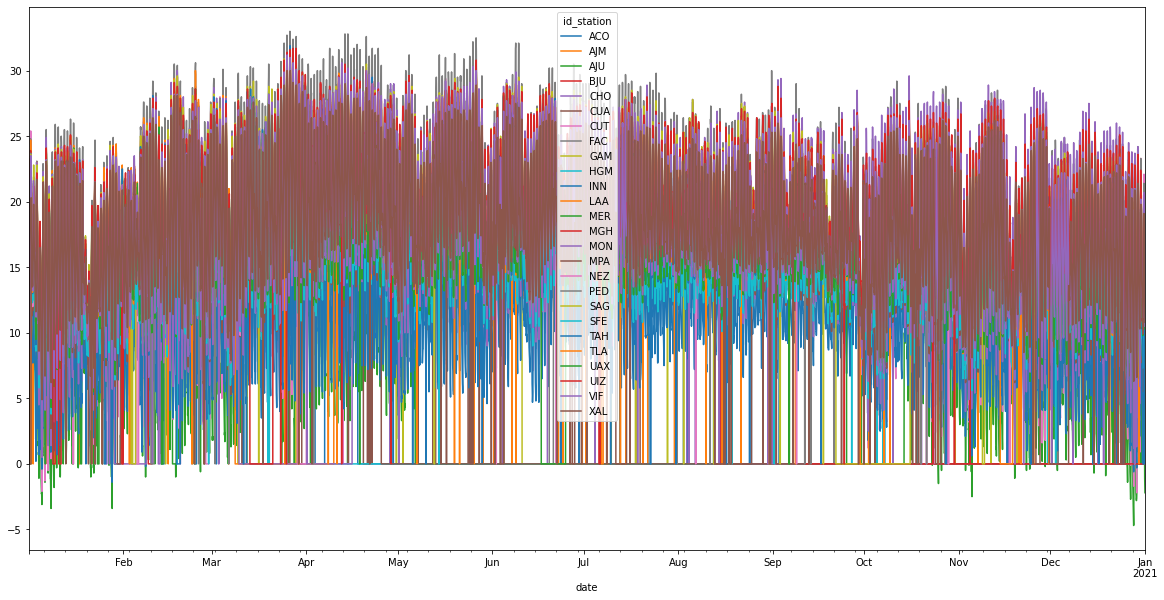

In [5]:
TMP = temp.loc["TMP"]
TMP = TMP.drop(columns=TMP.columns[TMP.eq(0.0).mean()>0.9])
TMP.plot(figsize = (20,10))

<AxesSubplot:xlabel='Hora'>

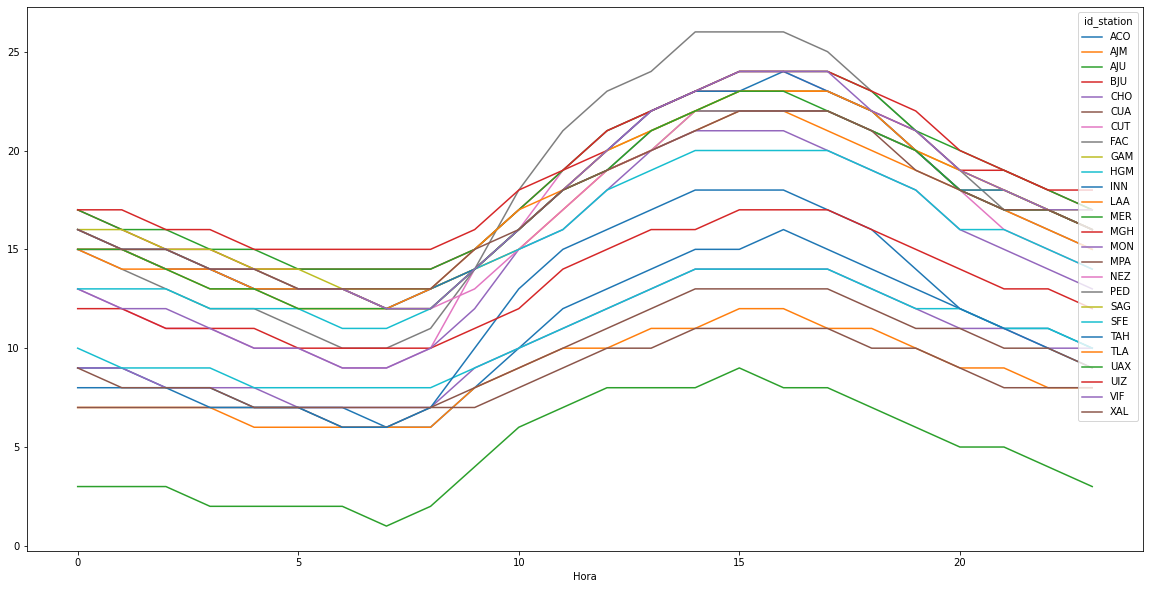

In [6]:
TMP_h = TMP.groupby(TMP.index.hour.rename('Hora')).mean().round()
TMP_h.plot(figsize = (20,10))

In [ ]:
plt.figure(figsize=(18,8))
sns.set(font_scale=1.4)
sns.heatmap(TMP_h.T,linewidths=0.5)
plt.ylabel('Estacion')

In [7]:
Temp = TMP_h.T.loc[:,6]
estaciones = estaciones.join(Temp)
estaciones.rename(columns={ estaciones.columns[-1]: "Temp"}, inplace = True )

In [18]:
Temp = TMP_h.T.loc[:,15]
estaciones = estaciones.join(Temp)
estaciones.rename(columns={ estaciones.columns[-1]: "Temp"}, inplace = True )

# Trabajo Geoespacial
Aquí primero convertimos nuestros valores ya un archivo de clase geoespacial

In [8]:
import fiona
import contextily as cx
import geopandas as gpd
from shapely.geometry import LineString
from osgeo import osr
from osgeo import ogr
from osgeo import gdal
import tifffile as tiff

In [9]:
estaciones_p = estaciones.copy()
estaciones_p = gpd.GeoDataFrame(
    estaciones_p, geometry=gpd.points_from_xy(estaciones["longitud"], estaciones["latitud"]))
estaciones_p.set_crs(epsg=4326, inplace=True)
estaciones_p.dropna(subset=['Temp'], inplace = True)
estaciones_p.to_file("estaciones.shp")

Visualización de las estaciones

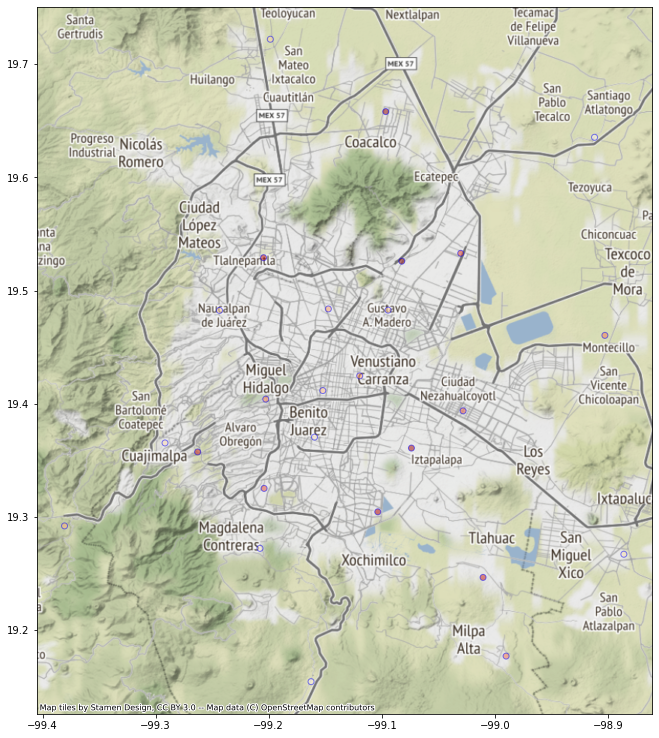

In [10]:
ax = estaciones_p.plot(figsize=(15, 13), alpha=0.5, edgecolor='b', cmap='OrRd', marker='o')
cx.add_basemap(ax, crs=estaciones_p.crs)

In [11]:
rasterDs = gdal.Grid('ICU.tif', 'estaciones.shp', format='GTiff',
               algorithm='invdist', zfield='Temp' )
rasterDs.FlushCache()

Basado en [Gidahatari](https://gidahatari.com/ih-es/como-convertir-un-raster-a-contornos-con-python-y-gdal-tutorial)

In [12]:
#Open tif file as select band
rasterDs = gdal.Open('ICU.tif')
rasterBand = rasterDs.GetRasterBand(1)
proj = osr.SpatialReference(wkt=rasterDs.GetProjection())

#Get elevation as numpy array
elevArray = rasterBand.ReadAsArray()
print(elevArray[:4,:4])

#define not a number
demNan = -32768

#get dem max and min
demMax = elevArray.max()
demMin = elevArray[elevArray!=demNan].min()
print("Maximun dem elevation: %.2f, minimum dem elevation: %.2f"%(demMax,demMin))

[[8.90136528 8.89935589 8.89761543 8.89565468]
 [8.8911581  8.88942623 8.8879137  8.88609886]
 [8.88038254 8.87911701 8.8777914  8.87621307]
 [8.86921883 8.8679924  8.86680222 8.86570263]]
Maximun dem elevation: 14.99, minimum dem elevation: 2.01


Contorno que se incrementa

In [13]:
contourPath = 'contoursIncremental.shp'
contourDs = ogr.GetDriverByName("ESRI Shapefile").CreateDataSource(contourPath)

#define layer name and spatial 
contourShp = contourDs.CreateLayer('contour', proj)

#define fields of id and elev
fieldDef = ogr.FieldDefn("ID", ogr.OFTInteger)
contourShp.CreateField(fieldDef)
fieldDef = ogr.FieldDefn("elev", ogr.OFTReal)
contourShp.CreateField(fieldDef)

#Write shapefile using noDataValue
#ContourGenerate(Band srcBand, double contourInterval, double contourBase, int fixedLevelCount, int useNoData, double noDataValue, 
#                Layer dstLayer, int idField, int elevField
gdal.ContourGenerate(rasterBand, 1, 1, [], 1, -32768, 
                     contourShp, 0, 1)

contourDs.Destroy()

In [14]:
from shapely import speedups #For reading the shape
speedups.disable()
lin = gpd.read_file("contoursIncremental.shp")

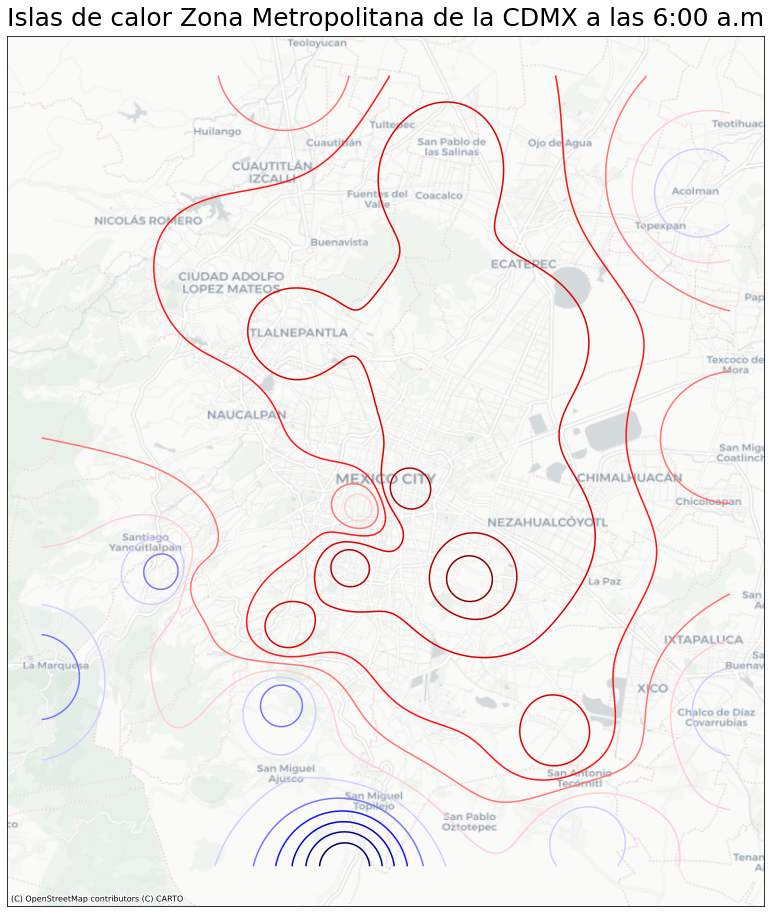

In [21]:
f, ax = plt.subplots(1,figsize=(20, 16))

# Removes ticks and labels for lat/lon
ax.tick_params(
    axis='both', bottom=False, left=False,         
    labelbottom=False, labelleft=False) 

lin.plot(ax = ax, categorical=True, column='elev', cmap='seismic')

ax.set_title('Islas de calor Zona Metropolitana de la CDMX a las 6:00 a.m', fontsize=25, pad=10)
ax.set_facecolor('black')
cx.add_basemap(ax, crs=lin.crs, source=cx.providers.CartoDB.Positron )

plt.show()

In [17]:
# Save figure
out_file = "Islas6.png"
ax.figure.savefig(out_file, bbox_inches="tight", dpi=600)